In [ ]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = '/content/drive/MyDrive/picture'
labels = '/content/drive/MyDrive/Color_label'

In [ ]:
import os
from glob import glob
import seaborn as sns
from PIL import Image

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

ims = [read(os.path.join(data, filename)) for filename in os.listdir(data)]
X_pic = np.array(ims, dtype='uint8')

for img in X_pic:
  img_X = np.resize(img , (288,288,3))
  print(img_X.shape)

In [ ]:
label = [read(os.path.join(labels, filename)) for filename in os.listdir(labels)]
y_pic = np.array(label, dtype='uint8')

for imu in y_pic:
  img_y = np.resize(imu, (288,288,3))

print(img_y.shape)

(288, 288, 3)


In [ ]:
import cv2
import os
img_X=[]
img_Y=[]
for i in os.listdir('/content/drive/MyDrive/picture'):
  img=cv2.imread('/content/drive/MyDrive/picture/'+i)
  img1=cv2.imread('/content/drive/MyDrive/Color_label/'+i)
  img1=cv2.resize(img1,(288,288))
  img=cv2.resize(img,(288,288))
  img_Y.append(img1)
  img_X.append(img)

img_X=np.asarray(img_X)
img_Y=np.asarray(img_Y)
print(np.asarray(img_X).shape)
print(np.asarray(img_Y).shape)

(117, 288, 288, 3)
(117, 288, 288, 3)


In [ ]:
img_X = img_X.astype('float16')
img_Y = img_Y.astype('float16')
img_X = img_X/255.
#X_train = np.reshape(X_train, (256,256,3))


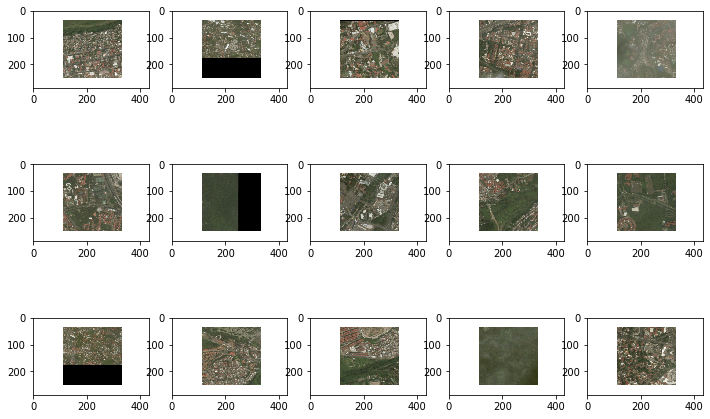

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(X_pic[i], interpolation='nearest')
plt.show()

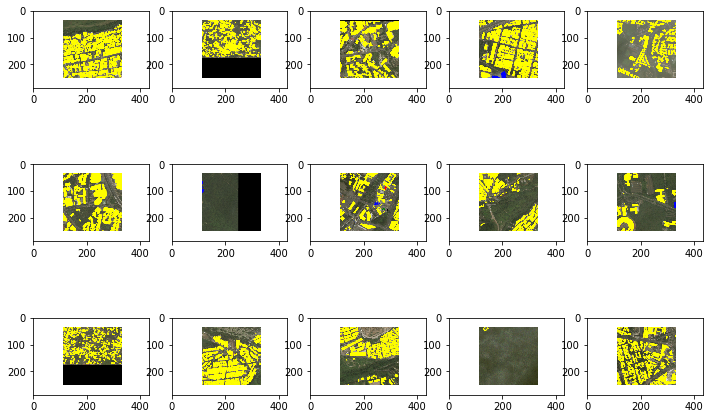

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(y_pic[i], interpolation='nearest')
plt.show()

In [ ]:
X_pic = X_pic.astype('float16')
y_pic = y_pic.astype('float16')
X_pic = X_pic/255.
#X_train = np.reshape(X_train, (256,256,3))


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(img_X, img_Y, test_size=0.3)

#X_train = np.reshape(X_train, (256,256,3))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(81, 288, 288, 3)
(81, 288, 288, 3)
(36, 288, 288, 3)
(36, 288, 288, 3)


In [ ]:
def conv2d_block(input_tensor,n_filters,kernel_size=3):
  x=input_tensor
  for i in range(2):
    x=tf.keras.layers.Conv2D(filters=n_filters,kernel_size=(kernel_size,kernel_size),padding='same')(x)
    x=tf.keras.layers.Activation('relu')(x)
  return x

In [ ]:
def encoder_block(inputs,n_filter,pool_size,dropout):
  f=conv2d_block(input_tensor=inputs,n_filters=n_filter)
  p=tf.keras.layers.MaxPooling2D(pool_size)(f)
  p=tf.keras.layers.Dropout(dropout)(p)
  return f,p

In [ ]:
def encoder(inputs):
  f1,p1=encoder_block(inputs,n_filter=64,pool_size=(2,2),dropout=0.3)
  f2,p2=encoder_block(p1,n_filter=128,pool_size=(2,2),dropout=0.3)
  f3,p3=encoder_block(p2,n_filter=256,pool_size=(2,2),dropout=0.3)
  f4,p4=encoder_block(p3,n_filter=512,pool_size=(2,2),dropout=0.3)
  return p4,(f1,f2,f3,f4)

In [ ]:
def bottleneck(inputs):
  bottle_neck=conv2d_block(inputs,n_filters=1024)
  return bottle_neck

In [ ]:
def decoder_block(inputs,conv_output,n_filter,kernel_size,strides,dropout):
  u=tf.keras.layers.Conv2DTranspose(n_filter,kernel_size,strides=strides,padding='same')(inputs)
  c=tf.keras.layers.concatenate([u,conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c=conv2d_block(c,n_filter,kernel_size=3)
  return c

In [ ]:
def decoder(inputs,convs):
  f1,f2,f3,f4=convs
  c6=decoder_block(inputs,f4,n_filter=512,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c7=decoder_block(c6,f3,n_filter=256,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c8=decoder_block(c7,f2,n_filter=128,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  c9=decoder_block(c8,f1,n_filter=64,kernel_size=(3,3),strides=(2,2),dropout=0.3)
  outputs=tf.keras.layers.Conv2D(1,kernel_size=(1,1),activation='relu')(c9)
  return outputs

In [ ]:
def unet():
  inputs=tf.keras.layers.Input(shape=(288,288,3,))
  encoder_output,convs=encoder(inputs)
  bottle_neck=bottleneck(encoder_output)
  outputs=decoder(bottle_neck,convs)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
def main():
  #train_images=np.asarray(pickle.load(open("/content/full_CNN_train.p","rb")),dtype=np.float32)
  #labels = np.asarray(pickle.load(open("/content/full_CNN_labels (1).p", "rb" )),dtype=np.float32)
  #train_images=train_images/255.0
  #labels=labels
  #train_images, labels = shuffle(train_images, labels)
  #X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
  model = unet()
  model.compile(optimizer='Adam', loss='mse',metrics=['accuracy'])
  model.fit(X_train,y_train,epochs=20,validation_data=(X_val, y_val))
  #model.save('full_CNN_model.h5')
  model.summary()

In [ ]:
if __name__ == '__main__':
  main()

In [ ]:
ResNet34, preprocess_input = Classifiers.get('resnet34')
Resmodel = ResNet34((288, 432, 3), weights='imagenet') 

In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()
N=X_train.shape[-1]
inp=tf.keras.Input(shape=(None,None,N))
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet', encoder_freeze=True)
l1=Conv2D(3,(1,1))(inp)
out=base_model(l1)
model=tf.keras.Model(inp,out,name=base_model.name)
model.compile(optimizer='Adam', loss='mse',metrics=['accuracy'])
model.fit(X_train,y_train,epochs=20,validation_data=(X_val, y_val))
model.summary()